In [6]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import Basemap
from matplotlib import cm
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\makae\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['Rectangle', 'Circle', 'Polygon']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [7]:
data = pd.read_csv('clean_may_data.csv')
df=pd.read_csv('cleaned_tripdata_2016-05.csv')
data.drop('Unnamed: 0',axis=1,inplace=True)
regions = pd.read_csv('regions.csv',sep=';')
df.dropna(inplace=True)

In [8]:
data_sum=pd.DataFrame(columns=['regions','sum_trips'])
data_sum.regions = [i for i in range(1,2501)]
data_sum.sum_trips = [data[data['region']==i]['trips'].sum() for i in range(1,2501)]

In [9]:
data_sum['long']=[((regions.west.values[i]+regions.east.values[i])/2) for i in range(2500)]
data_sum['lat']=[((regions.south.values[i]+regions.north.values[i])/2) for i in range(2500)]

In [10]:
data_sum['mean']=data_sum['sum_trips']/744.

Данные выглядят так, колонки long и lat указывают центр района и они здесь лишние =)

In [11]:
data_sum.head()

,regions,sum_trips,long,lat,mean
0,1,0.0,-74.250034,40.500314,0.0
1,2,0.0,-74.250034,40.508702,0.0
2,3,0.0,-74.250034,40.517090,0.0
3,4,0.0,-74.250034,40.525479,0.0
4,5,0.0,-74.250034,40.533867,0.0


Смотрим из скольких районов люди на такси не ездят

In [12]:
data_sum[data_sum['sum_trips']==0]['regions'].count()

1283

С помощью модуля basemap строим статическую карту и указываем на ней координату эмпаер стейт билдинг.
Видно, что в основном как раз ездят оттуда и немного с набережных

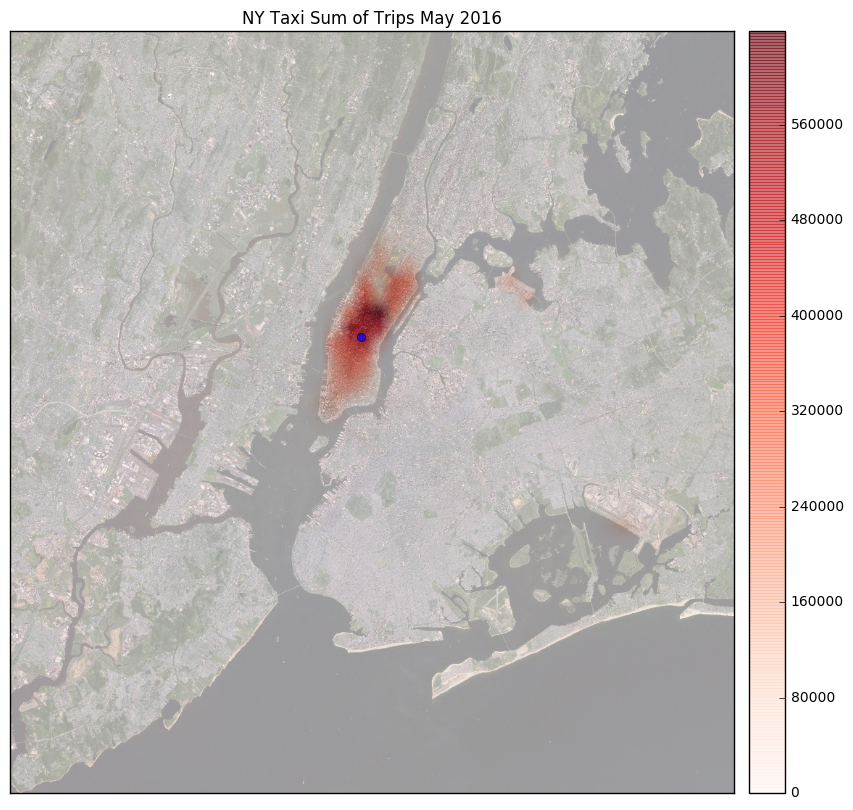

In [8]:
fig = plt.figure(figsize=(10,10))
empire_building_coord = (40.748433, -73.985656)
statue_liberty_coord = (40.689167, -74.044444)
ny_limits = (40.49612, 40.91553, -74.25559, -73.70001)
m = Basemap(llcrnrlat=ny_limits[0], urcrnrlat=ny_limits[1],
            llcrnrlon=ny_limits[2], urcrnrlon=ny_limits[3], epsg=2261)
m.arcgisimage(service='ESRI_Imagery_World_2D', xpixels = 1000)
m.plot(empire_building_coord[1], empire_building_coord[0], latlon=True, color='blue', marker='o', alpha=0.7)
m.imshow(np.reshape(data_sum.sum_trips.values, (50, 50), order='F'), cmap='Reds', alpha=0.6)
m.colorbar()
plt.title('NY Taxi Sum of Trips May 2016')
plt.show()

С помощью модуля ipyleaflet можно нарисовать интерактивную карту, к сожалению она не показывается в хтмл, поэтому в архиве еще есть картинка как выглядит при запуске ячейки

На карте видны несколько ячейк, откуда такси вызывали водолазы видимо =) Проверка показала, что в среднем в час из них поездок меньше 5, скорее всего это какие-то косяки gps

In [14]:
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)
center = [40.705825, -73.9778]
zoom=10
m2 = Map(center=center, zoom=zoom)
m2

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [15]:
poly2 = []
for i in range(2500):
    loc2 = [(regions.north.values[i],regions.east.values[i]),
           (regions.north.values[i],regions.west.values[i]),
           (regions.south.values[i],regions.west.values[i]),
           (regions.south.values[i],regions.east.values[i])]
    x = data_sum['mean'].values[i]
    if x==0:
        opa=0
    elif x<0.1:
        opa=0.3
    elif x<1.5:
        opa = 0.5
    elif x<12:
        opa = 0.7
    else:
        opa = 1
    pg2 = Polygon(locations=loc2, weight=1,
                color='#000', opacity=1, fill_opacity=opa,
                fill_color='#0f0b7c')
    poly2.append(pg2)
    m2.add_layer(pg2)

In [ ]:
mark2 = Marker(location=[40.689247,-74.044502])
m2 += mark2

Смотрим сколько районов из которых в среднем в час больше 5 вызовов такси

In [54]:
data_sum[data_sum['mean']>5].shape[0]

102